In [13]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
from src.constants import PATH_FINAL, PATH_DATABASE, PATH_MAX_GAN

In [15]:
con = duckdb.connect(":memory:", read_only=False)

In [16]:
con.sql(
    f"""
    CREATE OR REPLACE TABLE ganancia_maxima AS (
        SELECT
            *
        FROM read_parquet('{PATH_FINAL}')
        WHERE foto_mes >= 202104
    )
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [17]:
con.sql(
    """
    SELECT
        *
    FROM ganancia_maxima
    LIMIT 10
    """
)

┌───────────────────┬──────────┬────────────────┬───┬──────────────────────┬──────────────────────┐
│ numero_de_cliente │ foto_mes │ active_quarter │ … │ clase_ternaria_202…  │ clase_ternaria_202…  │
│       int64       │  int64   │     int64      │   │       varchar        │       varchar        │
├───────────────────┼──────────┼────────────────┼───┼──────────────────────┼──────────────────────┤
│         155318586 │   201902 │              1 │ … │ CONTINUA             │ CONTINUA             │
│         155318714 │   201902 │              1 │ … │ CONTINUA             │ CONTINUA             │
│         155326681 │   201902 │              1 │ … │ CONTINUA             │ CONTINUA             │
│         155330866 │   201902 │              1 │ … │ CONTINUA             │ CONTINUA             │
│         155331583 │   201902 │              1 │ … │ CONTINUA             │ CONTINUA             │
│         155332411 │   201902 │              1 │ … │ CONTINUA             │ CONTINUA             │


In [19]:
con.sql(
    """
    CREATE OR REPLACE TABLE ganancia_maxima AS (
        SELECT
            *,
            CASE 
                WHEN clase_ternaria_202109 = 'BAJA+2' THEN 270000
                ELSE 0
            END AS weights
        FROM ganancia_maxima
    )
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [20]:
con.sql(
    """
    SELECT
        *
    FROM ganancia_maxima
    LIMIT 10
    """
)

┌───────────────────┬──────────┬────────────────┬───┬──────────────────────┬──────────────────────┬─────────┐
│ numero_de_cliente │ foto_mes │ active_quarter │ … │ clase_ternaria_202…  │ clase_ternaria_202…  │ weights │
│       int64       │  int64   │     int64      │   │       varchar        │       varchar        │  int32  │
├───────────────────┼──────────┼────────────────┼───┼──────────────────────┼──────────────────────┼─────────┤
│         155318586 │   201902 │              1 │ … │ CONTINUA             │ CONTINUA             │       0 │
│         155318714 │   201902 │              1 │ … │ CONTINUA             │ CONTINUA             │       0 │
│         155326681 │   201902 │              1 │ … │ CONTINUA             │ CONTINUA             │       0 │
│         155330866 │   201902 │              1 │ … │ CONTINUA             │ CONTINUA             │       0 │
│         155331583 │   201902 │              1 │ … │ CONTINUA             │ CONTINUA             │       0 │
│         

In [52]:
df = con.sql(
    """
    SELECT
        foto_mes,
        (SUBSTR(foto_mes, 1, 4) || '-' || SUBSTR(foto_mes, 5, 2) || '-01')::DATE AS foto_mes_date,
        SUM(weights) AS ganancia_maxima
    FROM ganancia_maxima
    GROUP BY
        foto_mes
    """
).to_df()

In [53]:
df.head()

,foto_mes,foto_mes_date,ganancia_maxima
0,201901,2019-01-01,193320000.0
1,201902,2019-02-01,184680000.0
2,201903,2019-03-01,197100000.0
3,201904,2019-04-01,140130000.0
4,201905,2019-05-01,183600000.0


In [54]:
df["foto_mes_date"].unique()

<DatetimeArray>
['2019-01-01 00:00:00', '2019-02-01 00:00:00', '2019-03-01 00:00:00',
 '2019-04-01 00:00:00', '2019-05-01 00:00:00', '2019-06-01 00:00:00',
 '2019-07-01 00:00:00', '2019-08-01 00:00:00', '2019-09-01 00:00:00',
 '2019-10-01 00:00:00', '2019-11-01 00:00:00', '2019-12-01 00:00:00',
 '2020-01-01 00:00:00', '2020-02-01 00:00:00', '2020-03-01 00:00:00',
 '2020-04-01 00:00:00', '2020-05-01 00:00:00', '2020-06-01 00:00:00',
 '2020-07-01 00:00:00', '2020-08-01 00:00:00', '2020-09-01 00:00:00',
 '2020-10-01 00:00:00', '2020-11-01 00:00:00', '2020-12-01 00:00:00',
 '2021-01-01 00:00:00', '2021-02-01 00:00:00', '2021-03-01 00:00:00',
 '2021-04-01 00:00:00', '2021-05-01 00:00:00', '2021-06-01 00:00:00',
 '2021-07-01 00:00:00']
Length: 31, dtype: datetime64[ns]

In [55]:
df.isnull().sum()

foto_mes           0
foto_mes_date      0
ganancia_maxima    0
dtype: int64

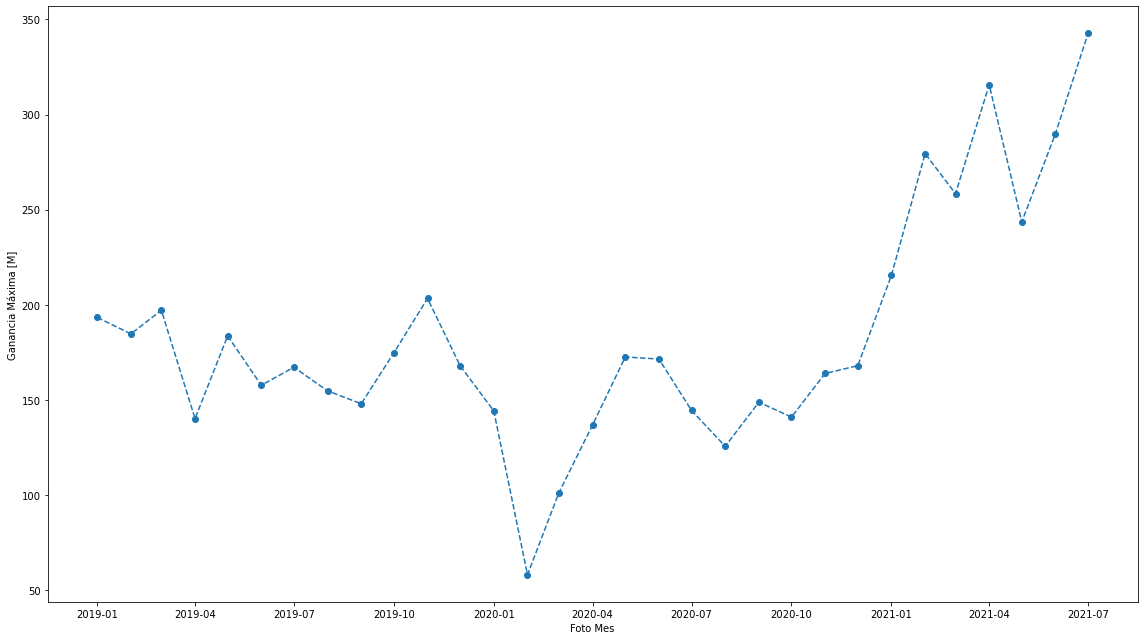

In [58]:
plt.figure(figsize=(16,9))
plt.plot(df["foto_mes_date"].values,df["ganancia_maxima"].values/1000000, 'o--')
plt.xlabel("Foto Mes")
plt.ylabel("Ganancia Máxima [M]")
plt.tight_layout()
plt.show()

In [61]:
df.to_parquet(PATH_MAX_GAN)